# Understand Open Pose

In this notebook we just play around with open pose, look at heatmaps and peaks

In [16]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import os
import sys

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))

import cv2
import nest_asyncio
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from deepexplain.tf.v1_x import DeepExplain
from plot_utils import plot_pose
from tf_pose import common
from tf_pose.common import CocoPart
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path
from tf_pose.tensblur.smoother import Smoother
from plot_utils import plot, plt



# Import DeepExplain

nest_asyncio.apply()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)
print(cv2.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4.1.0


In [7]:
# params 432, 368
w, h = 432, 368
image_path = '../data/images/muscle.jpg'
image_path_black = '../data/images/muscle_black1.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image = common.read_imgfile(image_path, w, h)
image_black = common.read_imgfile(image_path_black, w, h)

In [8]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_black = TfPoseEstimator(get_graph_path(
    model), target_size=(w, h), trt_bool=False)

In [9]:
# compute with and without
humans = e.inference(image, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)
humans_black = e_black.inference(image_black, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)

In [10]:
part = humans[0].body_parts[CocoPart.RShoulder.value]
print(f'ORIG: score: {part.score} x: {part.x} y: {part.y} ')
part = humans_black[0].body_parts[CocoPart.RShoulder.value]
print(f'OCCULED: score: {part.score} x: {part.x} y: {part.y} ')

ORIG: score: 0.6426067352294922 x: 0.39814814814814814 y: 0.2608695652173913 
OCCULED: score: 0.5812479853630066 x: 0.39814814814814814 y: 0.2391304347826087 


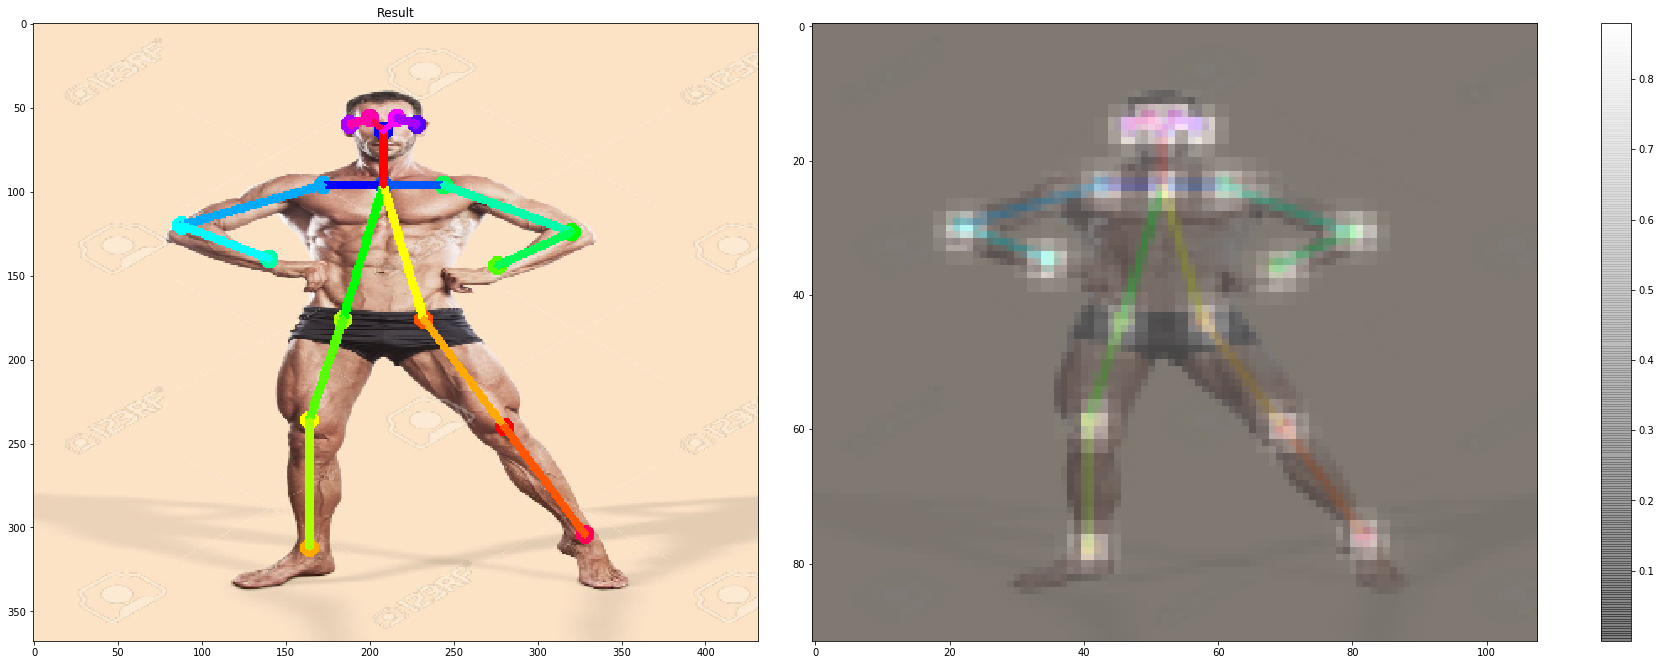

In [11]:
# estimate human poses from a single image !
humans_orig = e.inference(image, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)
# run again with parameters passed
plot_pose(image, humans_orig, e.heatMat)

In [12]:
# find part with smallest score
cur_min = 1.0
part = None
for body_part in humans[0].body_parts.keys():
    if humans[0].body_parts[body_part].score < cur_min:
        part = humans[0].body_parts[body_part]
        cur_min = humans[0].body_parts[body_part].score

print(part.get_part_name())

CocoPart.RHip


(?, ?, ?, 19)
(1, 92, 108, 19)
(?, 92, 108, 19)


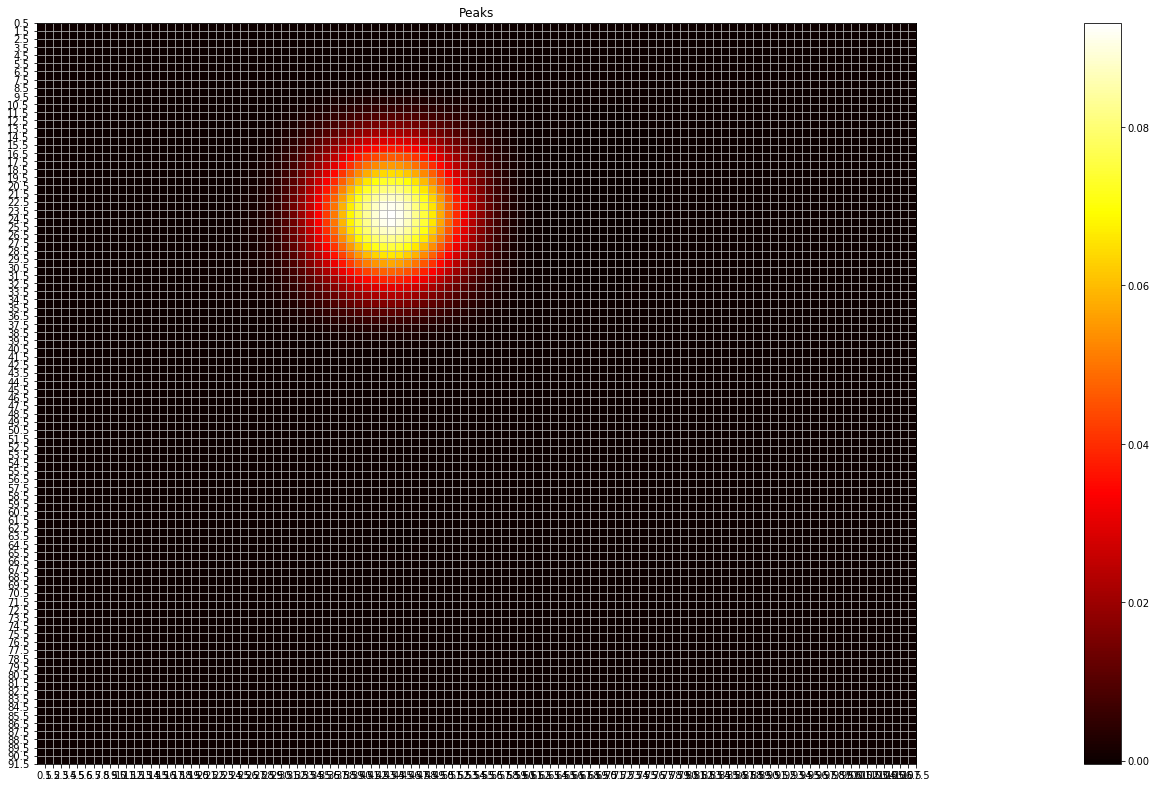

In [13]:
# REBUILD PEAKS

tensor_heatMat_up = tf.placeholder(
    dtype=tf.float32, shape=[None, 92, 108, 19], name='alex_test')

smoother = Smoother({'data': tensor_heatMat_up}, 25, 3.0)
gaussian_heatMat = smoother.get_output()

max_pooled_in_tensor = tf.nn.pool(gaussian_heatMat, window_shape=(
    3, 3), pooling_type='MAX', padding='SAME')
tensor_mask = tf.equal(gaussian_heatMat, max_pooled_in_tensor)
tensor_peaks = tf.where(tensor_mask, gaussian_heatMat,
                        tf.zeros_like(gaussian_heatMat))
e.persistent_sess.run(tf.variables_initializer(
    [v for v in tf.global_variables() if
     v.name.split(':')[0] in [x.decode('utf-8') for x in
                              e.persistent_sess.run(tf.report_uninitialized_variables())]
     ])
)

[tf_peaks] = e.persistent_sess.run(
    [tensor_peaks],
    feed_dict={
        tensor_heatMat_up: np.expand_dims(e.heatMat, axis=0)
    }
)
[tf_gaussian_heatMat] = e.persistent_sess.run(
    [gaussian_heatMat],
    feed_dict={
        tensor_heatMat_up: np.expand_dims(e.heatMat, axis=0)
    }
)
print(e.tensor_heatMat_up.shape)
print(tf_peaks.shape)
print(tensor_mask.shape)
fig = plt.figure(figsize=(60, 30))
ax = fig.add_subplot(2, 1, 1)

#heat_image = ax.imshow(tf_peaks[0,:,:,CocoPart.RShoulder.value], cmap=plt.cm.hot)
heat_image = ax.imshow(
    tf_gaussian_heatMat[0, :, :, CocoPart.RShoulder.value], cmap=plt.cm.hot)
ax.set_title('Peaks')

x_ticks = np.arange(0.5, e.peaks.shape[0], 1)
y_ticks = np.arange(0.5, e.peaks.shape[1], 1)

ax.set_xticks(y_ticks)
ax.set_yticks(x_ticks)

ax.grid()
fig.colorbar(heat_image, ax=ax, shrink=1.0)

(92, 108, 19)


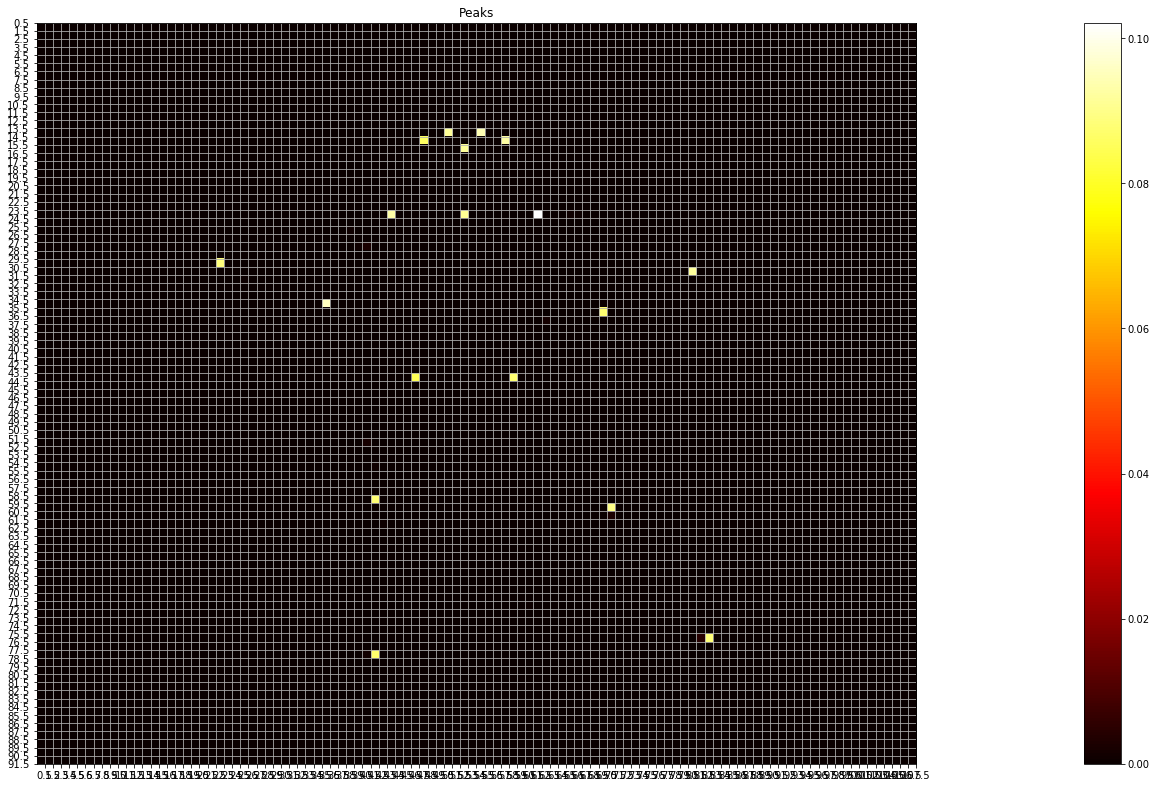

In [14]:
print(e.peaks.shape)
# show network output
peaks = np.amax(e.peaks[:, :, :-1], axis=2)
fig = plt.figure(figsize=(60, 30))
ax = fig.add_subplot(2, 1, 1)

heat_image = ax.imshow(peaks, cmap=plt.cm.hot)
ax.set_title('Peaks')

x_ticks = np.arange(0.5, e.peaks.shape[0], 1)
y_ticks = np.arange(0.5, e.peaks.shape[1], 1)

ax.set_xticks(y_ticks)
ax.set_yticks(x_ticks)

ax.grid()
fig.colorbar(heat_image, ax=ax, shrink=1.0)


In [ ]:
tmp = peaks > 0.05
cv2.imwrite("../results/plots/muscel_peaks.png", tmp * 255)

In [ ]:
heatmap = e.heatMat[:, :, CocoPart.RShoulder.value]
quantile = 0.99
quant = np.quantile(heatmap, quantile)
mask = heatmap > quant

# show network output
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(2, 1, 1)

heat_image = ax.imshow(heatmap, cmap=plt.cm.hot)
ax.set_title('Heatmap of Right Shoulder')
fig.colorbar(heat_image, ax=ax, shrink=1.0)

ax = fig.add_subplot(2, 2, 1)
ax.set_title(f'Mask with quantile = {quantile}')
ax.imshow(mask, cmap=plt.cm.hot)

In [ ]:
x, y = np.unravel_index(heatmap.argmax(), heatmap.shape)
print(f'Max value {heatmap[x, y]} at ({x}, {y})')
print(np.sum(heatmap))
print(e.heatMat.shape, str(type(e.heatMat)))
print(e.pafMat.shape, str(type(e.pafMat)))

print(e.tensor_output.shape, str(type(e.tensor_output)))
print(e.tensor_image.shape, str(type(e.tensor_image)))
print(mask.shape)

In [ ]:
# get the current session
sess = e.persistent_sess
# tf.reset_default_graph()
#sess = tf.Session()
LOGDIR = '../logs/openPose'

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=e.graph) as de:
    train_writer = tf.summary.FileWriter(LOGDIR)
    train_writer.add_graph(e.graph)

    input_tensor = e.tensor_image
    # output_tensor = e.tensor_heatMat[:, x, y, CocoPart.RShoulder.value] # DOES NOT WORK
    output_tensor = e.tensor_heatMat[:, :, :, CocoPart.RShoulder.value]
    xs = tf.expand_dims(image, 0).eval(session=sess)
    xs = xs.astype('float64')
    # print(output_tensor.shape, str(type(output_tensor)))
    # print(input_tensor.shape, str(type(input_tensor)))
    # print(xs.shape, str(type(xs)))
    # Y_shape=[None] + list(xs.shape[1:])
    Y_shape = [None] + [1, 46, 54]  # size of heatmaps with resize
    # ys = np.ones([1,] + Y_shape[1:])
    ys = np.expand_dims(np.expand_dims(mask, axis=0), axis=0)
    # print(Y_shape)
    baseline = np.zeros(list(xs.shape)[1:])  # baseline to compare against

    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        # 'Integrated Gradients': de.explain('intgrad',  T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        # 'Epsilon-LRP':          de.explain('elrp', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        # 'DeepLIFT (Rescale)':   de.explain('deeplift', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        # takes 4 hours and does not really work
        # 'Occlusion [15x15]':    de.explain('occlusion', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, window_shape=(15,15,3), step=4),
        # not feasable for that size of input
        # 'Shapley Sampling':     de.explain('shapley_sampling', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        'Saliency maps':        de.explain('saliency', T=output_tensor, X=input_tensor, xs=xs, ys=ys, Y_shape=Y_shape),
        'Gradient * Input':     de.explain('grad*input', T=output_tensor, X=input_tensor, xs=xs, ys=ys, Y_shape=Y_shape),
    }

In [ ]:
# Plot attributions
%matplotlib inline

n_cols = int(len(attributions)) + 1
n_rows = len(xs)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(
    3*n_cols*fig_scale, 3*n_rows*fig_scale))

for i, xi in enumerate(xs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, a in enumerate(attributions):
        axj = axes.flatten()[i*n_cols + j + 1]
        plot(attributions[a][i], xi=xi, axis=axj,
             dilation=.5, percentile=99, alpha=.2).set_title(a)